In [2]:
# Install gym
!pip install -q gym
!git clone https://github.com/gyyang/neurogym.git

Cloning into 'neurogym'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 3551 (delta 36), reused 37 (delta 17), pack-reused 3492
Receiving objects: 100% (3551/3551), 3.65 MiB | 47.25 MiB/s, done.
Resolving deltas: 100% (2501/2501), done.


In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.size'] = 7
mpl.rcParams['font.family'] = 'Arial'

import gym
from gym import spaces
import neurogym
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score

In [4]:
from neurogym.envs import ngym
from neurogym.ops import tasktools

class RDM(ngym.ngym):
    def __init__(self, dt=100,
                 fixation_min=300,
                 fixation_max=700,
                 stimulus_min=80,
                 stimulus_mean=330,
                 stimulus_max=1500,
                 decision=500,
                 p_catch=0.1,
                 stimEv=1.,
                 **kwargs):
        super().__init__(dt=dt)
        # Actions (fixate, left, right)
        # self.actions = [0, -1, 1]
        # trial conditions (left, right)
        # self.choices = [-1, 1]
        self.choices = [1, 2]
        # cohs specifies the amount of evidence (which is modulated by stimEv)
        self.cohs = np.array([0, 6.4, 12.8, 25.6, 51.2])*stimEv
        # Input noise
        self.sigma = np.sqrt(2*100*0.01)
        self.sigma_dt = self.sigma / np.sqrt(self.dt)
        # Durations (stimulus duration will be drawn from an exponential)
        # TODO: this is not natural
        self.fixation_mean = (fixation_max + fixation_min)/2
        self.fixation_min = fixation_min
        self.fixation_max = fixation_max
        self.stimulus_min = stimulus_min
        self.stimulus_mean = stimulus_mean
        self.stimulus_max = stimulus_max
        self.decision = decision
        self.mean_trial_duration = self.fixation_mean + self.stimulus_mean +\
            self.decision
        # TODO: How to make this easier?
        self.max_trial_duration = self.fixation_max + self.stimulus_max +\
            self.decision
        self.max_steps = int(self.max_trial_duration/dt)
        self.p_catch = p_catch
        if self.fixation_mean == 0 or self.decision == 0 or self.stimulus_mean == 0:
            print('XXXXXXXXXXXXXXXXXXXXXX')
            print('the duration of all periods must be larger than 0')
            print('XXXXXXXXXXXXXXXXXXXXXX')
        print('XXXXXXXXXXXXXXXXXXXXXX')
        print('Random Dots Motion Task')
        print('Mean Fixation: ' + str(self.fixation_mean))
        print('Min Stimulus Duration: ' + str(self.stimulus_min))
        print('Mean Stimulus Duration: ' + str(self.stimulus_mean))
        print('Max Stimulus Duration: ' + str(self.stimulus_max))
        print('Decision: ' + str(self.decision))
        print('(time step: ' + str(self.dt) + ')')
        print('XXXXXXXXXXXXXXXXXXXXXX')
        # Rewards
        self.R_ABORTED = -0.1
        self.R_CORRECT = +1.
        self.R_FAIL = 0.
        self.R_MISS = 0.
        self.abort = False
        # action and observation spaces
        self.stimulus_min = np.max([self.stimulus_min, dt])
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(-np.inf, np.inf, shape=(3,),
                                            dtype=np.float32)
        # seeding
        self.seed()
        self.viewer = None

        # start new trial
        # self.trial = self._new_trial()
        self._new_trial()

    def _new_trial(self):
        """
        _new_trial() is called when a trial ends to get the specifications of
        the next trial. Such specifications are stored in a dictionary with
        the following items:
            durations, which stores the duration of the different periods (in
            the case of rdm: fixation, stimulus and decision periods)
            ground truth: correct response for the trial
            coh: stimulus coherence (evidence) for the trial
        """
        # ---------------------------------------------------------------------
        # Epochs
        # ---------------------------------------------------------------------
        stimulus = tasktools.truncated_exponential(self.rng, self.dt,
                                                   self.stimulus_mean,
                                                   xmin=self.stimulus_min,
                                                   xmax=self.stimulus_max)
        fixation = self.rng.uniform(self.fixation_min, self.fixation_max)
        decision = self.decision
        
        # Introduce catch trials
        if self.rng.random() < self.p_catch:
            fixation = self.max_trial_duration
            stimulus = 0
            decision = 0
            self.catch = True
        else:
            self.catch = False
        
        
        # maximum length of current trial
        self.tmax = fixation + stimulus + decision
        durations = {
            'fixation': (0, fixation),
            'stimulus': (fixation, fixation + stimulus),
            'decision': (fixation + stimulus,
                         fixation + stimulus + decision),
            }
        self.fixation_0 = 0
        self.fixation_1 = fixation
        self.stimulus_0 = fixation
        self.stimulus_1 = fixation + stimulus
        self.decision_0 = fixation + stimulus
        self.decision_1 = fixation + stimulus + decision
        # ---------------------------------------------------------------------
        # Trial
        # ---------------------------------------------------------------------
        ground_truth = self.rng.choice(self.choices)
        coh = self.rng.choice(self.cohs)
        
        self.durations = durations
        self.ground_truth = ground_truth
        self.coh = coh
        
        t = np.arange(0, self.tmax, dt)
        
        obs = np.zeros((len(t), 3))
        
        fixation_period = np.logical_and(t>=self.fixation_0, t<self.fixation_1)
        stimulus_period = np.logical_and(t>=self.stimulus_0, t<self.stimulus_1)
        decision_period = np.logical_and(t>=self.decision_0, t<self.decision_1)

        obs[fixation_period, 0] = 1
        n_stim = int(stimulus/dt)
        obs[stimulus_period, 0] = 1
        obs[stimulus_period, ground_truth] = (1 + coh/100)/2
        obs[stimulus_period, 3 - ground_truth] = (1 - coh/100)/2
        # obs[stimulus_period][:, [1, 2]] += np.random.randn(n_stim, 2) * self.sigma_dt
        obs[stimulus_period] += np.random.randn(n_stim, 3) * self.sigma_dt
        self.obs = obs
        self.t = 0
        self.num_tr += 1
        self.gt = np.zeros((len(t),), dtype=np.int)
        self.gt[decision_period] = self.ground_truth

    def _step(self, action):
        """
        _step receives an action and returns:
            a new observation, obs
            reward associated with the action, reward
            a boolean variable indicating whether the experiment has end, done
            a dictionary with extra information:
                ground truth correct response, info['gt']
                boolean indicating the end of the trial, info['new_trial']
        """
        # TODO: Try pre-generating stimulus for each trial
        # ---------------------------------------------------------------------
        # Reward and observations
        # ---------------------------------------------------------------------
        new_trial = False
        # rewards
        reward = 0
        # observations
        if self.fixation_0 <= self.t < self.fixation_1:
            if action != 0:
                new_trial = self.abort
                reward = self.R_ABORTED
        elif self.decision_0 <= self.t < self.decision_1:
            if self.ground_truth == action:
                reward = self.R_CORRECT
            elif self.ground_truth == 3 - action:  # 3-action is the other action
                reward = self.R_FAIL
            new_trial = action != 0
        else:
            pass

        obs = self.obs[int(self.t/self.dt), :]

        # ---------------------------------------------------------------------
        # new trial?
        reward, new_trial = tasktools.new_trial(self.t, self.tmax,
                                                        self.dt,
                                                        new_trial,
                                                        self.R_MISS, reward)
        self.t += self.dt

        done = self.num_tr > self.num_tr_exp

        return obs, reward, done, {'new_trial': new_trial}

    def step(self, action):
        """
        step receives an action and returns:
            a new observation, obs
            reward associated with the action, reward
            a boolean variable indicating whether the experiment has end, done
            a dictionary with extra information:
                ground truth correct response, info['gt']
                boolean indicating the end of the trial, info['new_trial']
        Note that the main computations are done by the function _step(action),
        and the extra lines are basically checking whether to call the
        _new_trial() function in order to start a new trial
        """
        obs, reward, done, info = self._step(action)
        if info['new_trial']:
            self._new_trial()
        return obs, reward, done, info

    def reset(self):
        """
        restarts the experiment with the same parameters
        """
        self.perf = 0
        self.num_tr_perf = 0
        self.num_tr = 1
        self.t = 0

        self._new_trial()
        obs, _, _, _ = self.step(self.action_space.sample())
        return obs


In [5]:
# Get supervised learning data
from collections import defaultdict
dt = 20
# env = gym.make('RDM-v0', **{'dt': dt})
env = RDM(dt)
env.reset()

def get_supervised_data(batch_size):
    """Return data in batch, where each example is a trial"""
    X = np.zeros((env.max_steps, batch_size, env.observation_space.shape[0]))
    Y = np.zeros((env.max_steps, batch_size), dtype=np.int)
    M = np.zeros((env.max_steps, batch_size))

    # env.reset()
    for i in range(batch_size):
        env._new_trial()
        n_time = env.obs.shape[0]
        X[:n_time, i, :] = env.obs
        Y[:n_time, i] = env.gt
        M[:n_time, i] = 1
        
    X = X.astype(np.float32)

    return X, Y, M, None

XXXXXXXXXXXXXXXXXXXXXX
Random Dots Motion Task
Mean Fixation: 500.0
Min Stimulus Duration: 80
Mean Stimulus Duration: 330
Max Stimulus Duration: 1500
Decision: 500
(time step: 20)
XXXXXXXXXXXXXXXXXXXXXX


(135, 32, 3)
(135, 32)


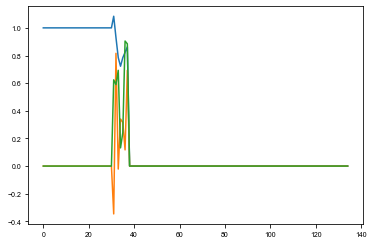

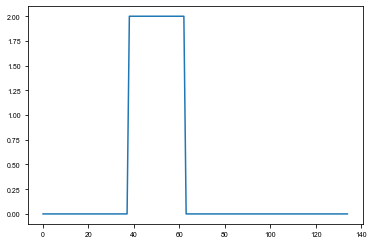

In [6]:
# Test if the data can be generated
X, Y, M, _ = get_supervised_data(32)
# plt.scatter(X[:, 0, 0], Y[:, 0])
print(X.shape)
print(Y.shape)

i = 2
plt.plot(X[:, i])
plt.figure()
plt.plot(Y[:, i])

In [7]:
# Define networks
from torch.nn import init
from torch.nn import functional as F
import math


class PosWLinear(nn.Module):
    r"""Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

    Same as nn.Linear, except that weight matrix is constrained to be non-negative
    """
    __constants__ = ['bias', 'in_features', 'out_features']

    def __init__(self, in_features, out_features, bias=True):
        super(PosWLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        # the default for Linear, kaiming_uniform wouldn't work here
        init.eye_(self.weight)
        self.weight.data = self.weight.data * 0.5  # scaled identity matrix
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        # weight is non-negative
        return F.linear(input, torch.abs(self.weight), self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )
    

class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, dt=None, batch_first=True):
        """Initialize params."""
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = 1
        self.batch_first = batch_first
        
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha

        self.input_weights = nn.Linear(input_size, hidden_size)
        self.hidden_weights = nn.Linear(hidden_size, hidden_size)

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        batch_size = input.shape[1]
        if hidden is None:
            hidden = self.initHidden(batch_size)
        
        def recurrence(input, hidden):
            """Recurrence helper."""
            pre_activation = self.input_weights(input) + self.hidden_weights(hidden)
            h_new = torch.relu(hidden * self.oneminusalpha +
                               pre_activation * self.alpha)  # n_b x hidden_dim

            return h_new

        if self.batch_first:
            input = input.transpose(0, 1)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = recurrence(input[i], hidden)
            output.append(hidden)

            # output.append(hidden[0] if isinstance(hidden, tuple) else hidden)
            # output.append(isinstance(hidden, tuple) and hidden[0] or hidden)

        output = torch.cat(output, 0).view(input.size(0), *output[0].size())

        if self.batch_first:
            output = output.transpose(0, 1)

        hidden = hidden.detach()
        return output, hidden
    
    def initHidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size).to('cuda')


class EIRNN(nn.Module):

    def __init__(self, input_size, hidden_size, dt=None, batch_first=True):
        """Initialize params."""
        super(EIRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.e_size = int(hidden_size*0.8)
        self.i_size = hidden_size - self.e_size
        self.num_layers = 1
        self.batch_first = batch_first
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha

        self.input_weights = nn.Linear(input_size, hidden_size)
        self.e_weights = PosWLinear(self.e_size, hidden_size)
        self.i_weights = PosWLinear(self.i_size, hidden_size)

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        batch_size = input.shape[1]
        if hidden is None:
            hidden = self.initHidden(batch_size)
        
        def recurrence(input, hidden):
            """Recurrence helper."""
            e_hidden, i_hidden = torch.split(
                hidden, (self.e_size, self.i_size), dim=1)
            pre_activation = (self.input_weights(input) + 
                              self.e_weights(e_hidden) -
                              self.i_weights(i_hidden))
            h_new = torch.relu(hidden * self.oneminusalpha +
                               pre_activation * self.alpha)  # n_b x hidden_dim

            return h_new

        if self.batch_first:
            input = input.transpose(0, 1)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = recurrence(input[i], hidden)
            output.append(hidden)

        output = torch.cat(output, 0).view(input.size(0), *output[0].size())

        if self.batch_first:
            output = output.transpose(0, 1)

        hidden = hidden.detach()
        return output, hidden
    
    def initHidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size).to('cuda')


class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, network='ei', dt=None):
        super(Net, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.network = network
        if network == 'lstm':
            self.rnn = nn.LSTM(input_size, hidden_size)
        elif network == 'rnn':
            self.rnn = RNN(input_size, hidden_size, batch_first=False)
        elif network == 'ei':
            self.rnn = EIRNN(input_size, hidden_size, dt=dt, batch_first=False)
        else:
            raise NotImplementedError('Unknown network', str(network))
        
        self.rnn_state = None
        if network == 'ei':
            self.fc = nn.Linear(self.rnn.e_size, output_size)
        else:
            self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # input size (seq_len, batch_size, input_size)
        # output size (seq_len, batch_size, output_size)
        batch_size = x.shape[1]
        rnn_out, self.rnn_state = self.rnn(x)
        if self.network == 'ei':
            rnn_e, rn_i = torch.split(
                rnn_out, (self.rnn.e_size, self.rnn.i_size), dim=2)
            out = self.fc(rnn_e)
        else:
            out = self.fc(rnn_out)

        return out, rnn_out

In [8]:
# Training networks
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device ', device)

input_size = env.observation_space.shape[0]
hidden_size = 100
output_size = env.action_space.n
batch_size = 256
l1_activity = 1e-1 * 0

net = Net(input_size, hidden_size, output_size, network='ei', dt=env.dt)
net = net.to(device)

# criterion = nn.CrossEntropyLoss(reduction='none')
criterion = nn.MSELoss(reduction='none')
optimizer = optim.Adam(net.parameters(), lr=0.001)

running_loss = 0.0
running_loss_reg = 0.0
running_acc = 0.0
print_every_steps = 200

import time
time_task = 0
time_net = 0
for i in range(1601):
    start_time = time.time()
    # env.reset()
    X, Y, M, _ = get_supervised_data(batch_size)
    time_task += time.time() - start_time

    start_time = time.time()
    # get the inputs; data is a list of [inputs, labels]
    inputs = torch.from_numpy(X).to(device)
    labels = torch.from_numpy(Y).to(device)
    mask = torch.from_numpy(M).to(device)
    mask = mask.view(-1)
    labels = labels.view(-1)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, rnn_out = net(inputs)
    outputs = outputs.view(-1, output_size)
    
    # loss = criterion(outputs, labels)
    loss = criterion(outputs, (F.one_hot(labels)).float())
    loss = torch.sum(loss, dim=1)
    
    mask_sum =  torch.sum(mask)
    loss_task = torch.sum(loss * mask) / mask_sum
    loss_reg = l1_activity * torch.mean(torch.abs(rnn_out))

    loss = loss_task + loss_reg

    acc = torch.sum(mask * (torch.argmax(outputs, axis=-1) == labels)) / mask_sum
    loss.backward()
    optimizer.step()

    time_net += time.time() - start_time

    # print statistics
    running_loss += loss.item()
    running_loss_reg += loss_reg.item()
    running_acc += acc.item()
    if i % print_every_steps == 0:    # print every 2000 mini-batches
        running_loss /= print_every_steps
        running_loss_reg /= print_every_steps
        running_acc /= print_every_steps
        print('[{:5d}] loss: {:0.3f}, loss reg: {:0.3f}, acc: {:0.3f}'.format(
            i + 1, running_loss, running_loss_reg, running_acc))
        running_loss = 0.0
        running_loss_reg = 0.0
        running_acc = 0.0
        print('Total time on task {:0.3f}s, net {:0.3f}s'.format(time_task, time_net))

print('Finished Training')

Using device  cuda
[    1] loss: 0.006, loss reg: 0.000, acc: 0.001
Total time on task 0.015, net 0.254
[  201] loss: 0.286, loss reg: 0.000, acc: 0.829
Total time on task 3.152, net 17.251
[  401] loss: 0.148, loss reg: 0.000, acc: 0.925
Total time on task 6.591, net 34.424
[  601] loss: 0.121, loss reg: 0.000, acc: 0.930
Total time on task 10.068, net 51.707


KeyboardInterrupt: 

In [9]:
#  Get validation data
env_val = RDM(dt,
              fixation_min=500,
              fixation_max=500,
              stimulus_min=800,
              stimulus_max=800,
              stimulus_mean=800,
              p_catch=0,
             )
env_val.reset()

def get_validation_data(batch_size):
    """Return data in batch, where each example is a trial"""
    X = np.zeros((env_val.max_steps, batch_size, env_val.observation_space.shape[0]))
    Y = np.zeros((env_val.max_steps, batch_size), dtype=np.int)
    M = np.zeros((env_val.max_steps, batch_size))
    meta_data = defaultdict(list)

    for i in range(batch_size):
        env_val._new_trial()
        n_time = env_val.obs.shape[0]
        X[:n_time, i, :] = env_val.obs
        Y[:n_time, i] = env_val.gt
        M[:n_time, i] = 1
        
        meta_data['coh'].append(env_val.coh)
        meta_data['ground_truth'].append(env_val.ground_truth)
    
    X = X.astype(np.float32)
    
    for key, val in meta_data.items():
        meta_data[key] = np.array(val)

    return X, Y, M, meta_data

XXXXXXXXXXXXXXXXXXXXXX
Random Dots Motion Task
Mean Fixation: 500.0
Min Stimulus Duration: 800
Mean Stimulus Duration: 800
Max Stimulus Duration: 800
Decision: 500
(time step: 20)
XXXXXXXXXXXXXXXXXXXXXX


In [10]:
import time
# Analyze networks. This can take up to 30 seconds
start_time = time.time()
env.reset()
X, Y, M, meta_data = get_validation_data(4096)
M = M > 0.5
print('Task time taken', time.time() - start_time)
# get the inputs; data is a list of [inputs, labels]
inputs = torch.from_numpy(X).to(device)
labels = torch.from_numpy(Y).to(device)
labels = labels.view(-1)

# forward + backward + optimize
start_time = time.time()
outputs, rnn_out = net(inputs)
print('Net time taken', time.time() - start_time)
outputs = outputs.detach().cpu().numpy()
rnn_out = rnn_out.detach().cpu().numpy()

Task time taken 0.23513054847717285
Net time taken 0.03182554244995117


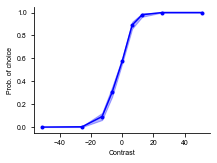

In [11]:
# Psychometric curve
ground_truth = (meta_data['ground_truth']*2-3)  # convert to -1 and 1
meta_data['signed_coh'] = meta_data['coh'] * ground_truth
outputs_ = np.argmax(outputs, axis=-1)
meta_data['actual_choice'] = np.array(
    [outputs_[:, i][M[:, i]][-1] for i in range(X.shape[1])])
meta_data['actual_choice'] -= 1  # move to 0 and 1

def get_sorted_values(sort_by, avg_var, condition_var=None, condition_val=None):
    unique_vals = np.unique(meta_data[sort_by])
    values = list()
    mean_values = list()
    confint_lows = list()
    confint_highs = list()
    for val in unique_vals:
        ind = meta_data[sort_by] == val
        if condition_var is not None:
            ind_condition = meta_data[condition_var] == condition_val
            ind *= ind_condition
        value = meta_data[avg_var][ind]
        values.append(value)
        mean_values.append(np.mean(value))

        means = [np.mean(np.random.choice(value, size=len(value))) for i in range(100)]
        confint = np.percentile(means, [2.5, 97.5])
        confint_lows.append(confint[0])
        confint_highs.append(confint[1])

    return unique_vals, mean_values, confint_lows, confint_highs

sort_by = 'signed_coh'  # sort by this variable
avg_var = 'actual_choice'  # average this variable

nicenames = {'signed_coh': 'Contrast',
             'actual_choice': 'Prob. of choice'}

fig = plt.figure(figsize=(3.5, 2.5))
ax = fig.add_axes([0.2, 0.2, 0.7, 0.7])
# unique_vals, mean_values = get_sorted_values(sort_by, avg_var)
# plt.plot(unique_vals, mean_values, 'o-', label='both')
    
unique_vals, mean_values, confint_lows, confint_highs = get_sorted_values(
    sort_by, avg_var)
ax.plot(unique_vals, mean_values, 'o-', markersize=3, color='blue')
ax.fill_between(unique_vals, confint_lows, confint_highs, color='blue', alpha=0.3)
plt.xlabel(nicenames[sort_by])
plt.ylabel(nicenames[avg_var])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

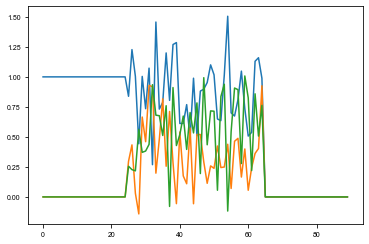

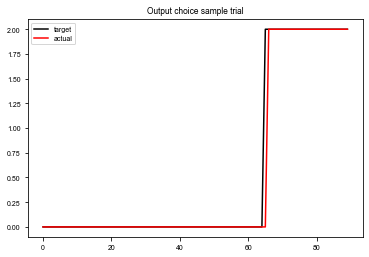

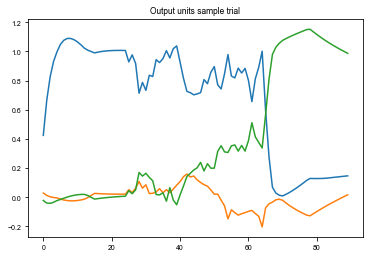

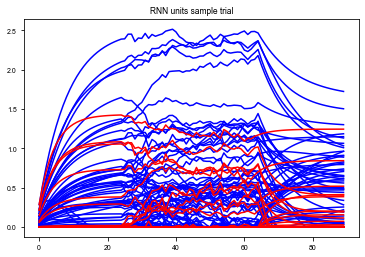

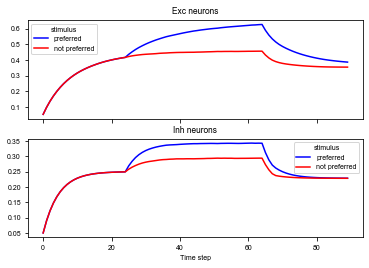

In [12]:
# All time points are valid in validation mode
# rnn_out (seq_len, batch_size, units)
r_pos = rnn_out[:, meta_data['signed_coh']>0, :].mean(axis=1)
r_neg = rnn_out[:, meta_data['signed_coh']<0, :].mean(axis=1)
# neuronal preferences
prefs = r_pos[-1, :] > r_neg[-1, :]

# Get neurons's activity for preferred stimuli
r_pref = np.zeros((rnn_out.shape[0], hidden_size))
r_nopref = np.zeros((rnn_out.shape[0], hidden_size))
for i in range(hidden_size):
    if prefs[i]:
        r_pref[:, i] = r_pos[:, i]
        r_nopref[:, i] = r_neg[:, i]
    else:
        r_pref[:, i] = r_neg[:, i]
        r_nopref[:, i] = r_pos[:, i]
        
# ind_exc = np.arange(hidden_size) < net.rnn.e_size
# ind_inh = np.arange(hidden_size) >= net.rnn.e_size

ind_exc = np.arange(hidden_size) < int(0.8*hidden_size)
ind_inh = np.arange(hidden_size) >= int(0.8*hidden_size)

plt.figure()
plt.plot(X[:, 0, :])

plt.figure()
plt.plot(Y[:, 0], 'black', label='target')
plt.plot(outputs_[:, 0], 'red', label='actual')
plt.legend()
plt.title('Output choice sample trial')

plt.figure()
plt.plot(outputs[:, 0, :])
plt.title('Output units sample trial')

plt.figure()
plt.plot(rnn_out[:, 0, ind_exc], color='blue')
plt.plot(rnn_out[:, 0, ind_inh], color='red')
plt.title('RNN units sample trial')

fig, axes = plt.subplots(2, 1, sharex=True)
inds = [ind_exc, ind_inh]
names = ['Exc', 'Inh']
for i in [0, 1]:
    ax = axes[i]
    _ = ax.plot(r_pref[:, inds[i]].mean(axis=-1), 'blue', label='preferred')
    _ = ax.plot(r_nopref[:, inds[i]].mean(axis=-1), 'red', label='not preferred')
    ax.set_title(names[i] + ' neurons')
    ax.legend(title='stimulus')
    if i == 1:
        plt.xlabel('Time step')